# Generating Synthetic Data MRI Images using GANs

# Importing necessary libraries


In [19]:
# import necessary libs

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np 
import matplotlib.pyplot as plt
import os
import time
import cv2
import glob

# Data Preparation

In [20]:
def load_real_mri_images(folder_path="/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset", 
                         image_size=(128, 128), limit=None):
    images = []
    image_paths = glob.glob(folder_path + '/*/*.jpg')
    if limit:
        image_paths = image_paths[:limit]
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, image_size)
        img = (img.astype('float32') / 127.5) - 1.0 # [-1, 1] aralığına normalize
        images.append(img)
    images = np.array(images)[..., np.newaxis]
    return images

#generate synthetic MRI-like data
num_samples = 5000
image_size = (128, 128)
x = load_real_mri_images(image_size=(128, 128), limit=None)
print("MRI data shape:", x.shape)

MRI data shape: (171, 128, 128, 1)


In [21]:
#DATA AUGMENTATION

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(images, times=5):
    datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2,
                                 width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    augmented = []
    for _ in range(times):
        for img in images:
            img = img.reshape((1,) + img.shape)  # reshape for generator
            for batch in datagen.flow(img, batch_size=1):
                augmented.append(batch[0])
                break  # only one augmented version
    return np.array(augmented)

augmented_images = augment_images(x, times=5)
x = np.concatenate([x, augmented_images])
np.random.shuffle(x)


print("Augmented MRI shape:", x.shape)


Augmented MRI shape: (1026, 128, 128, 1)


171 görüntü bulundu.


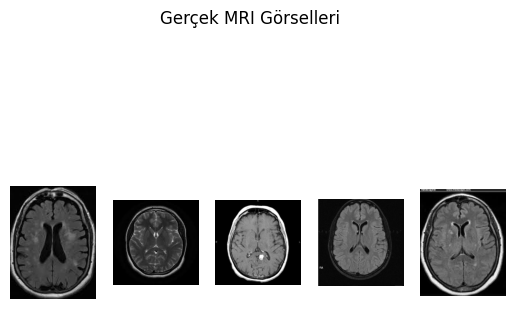

In [22]:
import cv2
import matplotlib.pyplot as plt
import glob

image_paths = glob.glob("/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/*/*.jpg")
print(f"{len(image_paths)} görüntü bulundu.")

# İlk 5 resmi göster
for i in range(5):
    img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle("Gerçek MRI Görselleri")
plt.show()


# Data Loading and Preprocessing

In [23]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(x, test_size=0.2, random_state=42)

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")

Training set shape: (820, 128, 128, 1)
Validation set shape: (206, 128, 128, 1)


# Generator

In [24]:
#The generator takes random noise as input and generates synthetic MRI images.

def build_generator(noise_dim=100):
    model = tf.keras.Sequential(name='Generator')

    model.add(layers.Dense(32 * 32 * 256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256) # None is the batch size
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose( 64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 128, 128, 1)
    
    return model

#Instantiate the generator
noise_dim = 100
generator = build_generator(noise_dim)
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 262144)              │      26,214,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 262144)              │       1,048,576 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 64, 64, 128)         │         819,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 128, 128, 64)        │         204,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 128, 128, 1)         │           1,600 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,289,344 (107.92 MB)

 Trainable params: 27,764,672 (105.91 MB)

 Non-trainable params: 524,672 (2.00 MB)

# Discriminator

In [25]:
# The discriminator takes an MRI image as input and outputs a single scalar value indicating real or fake.

def build_discriminator():
    model = tf.keras.Sequential(name='Discriminator')

    model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[128, 128,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

#Instantiate the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │         131,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337,665 (1.29 MB)

 Trainable params: 337,665 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

# Training the GAN


In [26]:
"""Loss Functions and Optimizers
We'll use Binary Crossentropy loss for both generator and discriminator. 

Adam optimizers are used for both networks."""

#Define the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) #try to label fake as 1

#define the optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training the Loop

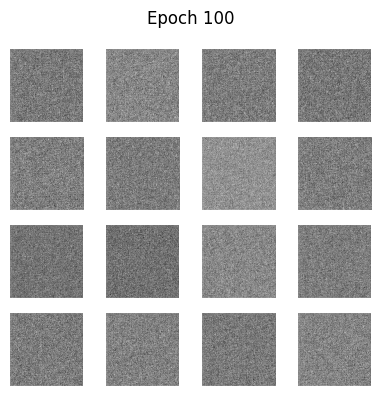

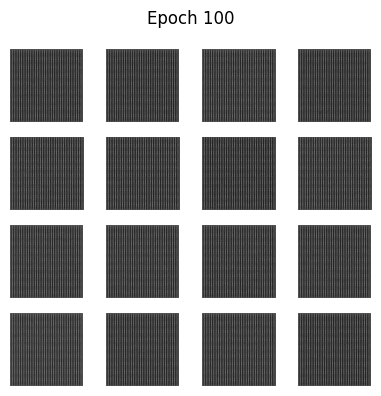

Epoch 100, Generator Loss: 4.1570,Discriminator Loss: 0.6326, Time: 163.960400 sec


In [27]:
#Define training parameters
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 6000

#Create batches of data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#Define the generator and discriminator
generator = build_generator(noise_dim)
discriminator = build_discriminator()

#Define the training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

#function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    #notice 'training' is set to False
    #this is so all layers run in inference mode(batchnorm)
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()
    plt.close(fig)

#seed for gwnwrating images
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#training loop
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        start = time.time()

    for image_batch in dataset:
        gen_loss, disc_loss = train_step(image_batch)

    #produce images for the GIF as we go
    generate_and_save_images(generator, epoch, seed)

    print (f'Epoch {epoch}, Generator Loss: {gen_loss.numpy():.4f},Discriminator Loss: {disc_loss.numpy():.4f}, Time: {time.time()-start:2f} sec')

#Generate after the final epoch
generate_and_save_images(generator, EPOCHS, seed)

#start training
train(train_dataset, EPOCHS)